## TP4 - Prédiction du prix d'un vol avec le Boosting

À partir de [datasets](https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction), on souhaite prédire le prix d'un vol. Nous travaillerons avec les datasets brut, pas ceux pré-traité par les personnes qui l'ont publié sur Kaggle. Il y aura deux datasets que l'on va utiliser pour former un dataset plus complet.

In [29]:
import numpy as np
import pandas as pd


economy = pd.read_csv("economy.csv")
economy["Type"] = "Economy"

business = pd.read_csv("business.csv")
business["Type"] = "Business"

df = pd.concat((economy, business))
df.reset_index(inplace=True, drop=True)
df.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,Type
0,11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953",Economy
1,11-02-2022,SpiceJet,SG,8157,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,"5,953",Economy
2,11-02-2022,AirAsia,I5,764,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,"5,956",Economy
3,11-02-2022,Vistara,UK,995,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,"5,955",Economy
4,11-02-2022,Vistara,UK,963,08:50,Delhi,02h 20m,non-stop,11:10,Mumbai,"5,955",Economy


## Exploration et nettoyage

Commençons par explorer les données. On veut s'assurer de la cohérence des données et identifier des variables qui pourraient être importante dans la modélisation.

**Consigne** : Modifier l'ensemble des noms de colonnes pour qu'ils commençent par une capitale. Puis supprimer les colonnes *Ch_code* et *Num_code*.

In [30]:
# Mettre en majuscules les noms des colonnes
df.columns = [col.capitalize() for col in df.columns]

# Supprimer les colonnes "Ch_code" et "Num_code"
df.drop(columns=["Ch_code", "Num_code"], inplace=True)

# Afficher les premières lignes pour vérifier
df.head()

,Date,Airline,Dep_time,From,Time_taken,Stop,Arr_time,To,Price,Type
0,11-02-2022,SpiceJet,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953",Economy
1,11-02-2022,SpiceJet,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,"5,953",Economy
2,11-02-2022,AirAsia,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,"5,956",Economy
3,11-02-2022,Vistara,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,"5,955",Economy
4,11-02-2022,Vistara,08:50,Delhi,02h 20m,non-stop,11:10,Mumbai,"5,955",Economy


Les colonnes *Date*, *Dep_time*, *Time_taken* et *Arr_time* correspondent toute à des dates ou durée. Mettons-les au bon format.

### Travail des dates et des temps

**Consigne** : A l'aide de la fonction [`pd.to_datetime`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html), modifier la colonne *Date* puis créer la colonne *Flight_month* qui contient le mois du vol.

In [31]:
# df["Date"] = df["Date"].apply(lambda x: x.replace("-", "/"))
# df["Date"] = pd.to_datetime(df["Date"], errors='coerce')

# df.head()

# Convertir la colonne "Date" en format datetime
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Créer une nouvelle colonne "Flight_month" qui contient le mois du vol
df['Flight_month'] = df['Date'].dt.month

# Afficher les premières lignes pour vérifier
df.head()

,Date,Airline,Dep_time,From,Time_taken,Stop,Arr_time,To,Price,Type,Flight_month
0,2022-02-11,SpiceJet,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953",Economy,2
1,2022-02-11,SpiceJet,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,"5,953",Economy,2
2,2022-02-11,AirAsia,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,"5,956",Economy,2
3,2022-02-11,Vistara,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,"5,955",Economy,2
4,2022-02-11,Vistara,08:50,Delhi,02h 20m,non-stop,11:10,Mumbai,"5,955",Economy,2


**Consigne** : Remplacer la colonne *Dep_time* par une colonne *Departure_hour* qui ne conserve que l'heure de départ. Faire de même avec la colonne *Arr_time* par *Arrival_hour*.

In [32]:
# df["Departure_hour"] = df["Dep_time"].apply(lambda x: x.split(":")[0])
# df["Arrival_hour"] = df["Arr_time"].apply(lambda x: x.split(":")[0])

# # Afficher les premières lignes pour vérifier
# df.head()

# Extraire uniquement l'heure de départ pour la colonne "Dep_time" et créer "Departure_hour"
df['Departure_hour'] = pd.to_datetime(df['Dep_time'], format='%H:%M').dt.hour

# Extraire uniquement l'heure d'arrivée pour la colonne "Arr_time" et créer "Arrival_hour"
df['Arrival_hour'] = pd.to_datetime(df['Arr_time'], format='%H:%M').dt.hour

# Supprimer les colonnes originales "Dep_time" et "Arr_time"
df.drop(columns=['Dep_time', 'Arr_time'], inplace=True)

# Afficher les premières lignes pour vérifier
df.head()

,Date,Airline,From,Time_taken,Stop,To,Price,Type,Flight_month,Departure_hour,Arrival_hour
0,2022-02-11,SpiceJet,Delhi,02h 10m,non-stop,Mumbai,"5,953",Economy,2,18,21
1,2022-02-11,SpiceJet,Delhi,02h 20m,non-stop,Mumbai,"5,953",Economy,2,6,8
2,2022-02-11,AirAsia,Delhi,02h 10m,non-stop,Mumbai,"5,956",Economy,2,4,6
3,2022-02-11,Vistara,Delhi,02h 15m,non-stop,Mumbai,"5,955",Economy,2,10,12
4,2022-02-11,Vistara,Delhi,02h 20m,non-stop,Mumbai,"5,955",Economy,2,8,11


On souhaite également créer la colonne *Flight_time* à partir de la colonne *Time_taken* qui correspondra à la durée du vol en minutes.

In [33]:
import re

def convert_to_time(string_time):
    pattern = r'(\d+)h (\d+)m'
    match = re.match(pattern, string_time)
    if match:
        hours = int(match.group(1))
        minutes = int(match.group(2))
    else:
        hours, minutes = 0, 0
    return 60 * hours + minutes

df["Flight_time"] = df["Time_taken"].apply(lambda time: convert_to_time(time))
df = df.drop(columns=["Time_taken"], axis=1)

### Autre colonnes

**Consigne** : Explorer la colonne *Stop* et en extraire le nombre d'escale qui sont réalisés. La colonne sera catégorielle.

In [34]:
# Mapper les valeurs de "Stop" pour obtenir le nombre d'escales
df['Stops'] = df['Stop'].apply(lambda x: 0 if 'non-stop' in x else int(x[0]))

# Supprimer la colonne "Stop" originale
df.drop(columns=['Stop'], inplace=True)

# Afficher les premières lignes pour vérifier
df.head()

,Date,Airline,From,To,Price,Type,Flight_month,Departure_hour,Arrival_hour,Flight_time,Stops
0,2022-02-11,SpiceJet,Delhi,Mumbai,"5,953",Economy,2,18,21,130,0
1,2022-02-11,SpiceJet,Delhi,Mumbai,"5,953",Economy,2,6,8,140,0
2,2022-02-11,AirAsia,Delhi,Mumbai,"5,956",Economy,2,4,6,130,0
3,2022-02-11,Vistara,Delhi,Mumbai,"5,955",Economy,2,10,12,135,0
4,2022-02-11,Vistara,Delhi,Mumbai,"5,955",Economy,2,8,11,140,0


**Consigne** : A l'aide de la méthode `info`, identifier puis corriger le problème de la colonne *Price*.

In [35]:
df.info()
df["Price"] = df["Price"].apply(lambda x: x.replace(",", "."))
df["Price"] = pd.to_numeric(df["Price"], errors='coerce')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300261 entries, 0 to 300260
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Date            300261 non-null  datetime64[ns]
 1   Airline         300261 non-null  object        
 2   From            300261 non-null  object        
 3   To              300261 non-null  object        
 4   Price           300261 non-null  object        
 5   Type            300261 non-null  object        
 6   Flight_month    300261 non-null  int32         
 7   Departure_hour  300261 non-null  int32         
 8   Arrival_hour    300261 non-null  int32         
 9   Flight_time     300261 non-null  int64         
 10  Stops           300261 non-null  int64         
dtypes: datetime64[ns](1), int32(3), int64(2), object(5)
memory usage: 21.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300261 entries, 0 to 300260
Data columns (total 11 columns):
 #   Colu

**Consigne** : Remplacer la variable *Type* par une valeur 0 ou 1 (pour business). On modifiera le nom de la colonne en conséquence.

In [36]:
df["Type"] = df["Type"].apply(lambda x: 0 if x == "Economy" else 1)
df.rename({"Type": "isBusiness"}, axis=1, inplace=True)
df.head()

,Date,Airline,From,To,Price,isBusiness,Flight_month,Departure_hour,Arrival_hour,Flight_time,Stops
0,2022-02-11,SpiceJet,Delhi,Mumbai,5.953,0,2,18,21,130,0
1,2022-02-11,SpiceJet,Delhi,Mumbai,5.953,0,2,6,8,140,0
2,2022-02-11,AirAsia,Delhi,Mumbai,5.956,0,2,4,6,130,0
3,2022-02-11,Vistara,Delhi,Mumbai,5.955,0,2,10,12,135,0
4,2022-02-11,Vistara,Delhi,Mumbai,5.955,0,2,8,11,140,0


**Consigne** : Afficher la représentativité de chaque compagnie aérienne en utilisant la méthode [`value_counts`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html). Faire de même avec les colonnes *From* et *To* puis commenter.

In [39]:
# Afficher la représentativité de chaque compagnie aérienne
airline_counts = df['Airline'].value_counts()
print("Représentativité de chaque compagnie aérienne:")
print(airline_counts)

# Afficher la représentativité de chaque ville de départ
from_counts = df['From'].value_counts()
print("\nReprésentativité de chaque ville de départ:")
print(from_counts)

# Afficher la représentativité de chaque ville d'arrivée
to_counts = df['To'].value_counts()
print("\nReprésentativité de chaque ville d'arrivée:")
print(to_counts)

Représentativité de chaque compagnie aérienne:
Airline
Vistara      127859
Air India     80894
Indigo        43120
GO FIRST      23177
AirAsia       16098
SpiceJet       9011
StarAir          61
Trujet           41
Name: count, dtype: int64

Représentativité de chaque ville de départ:
From
Delhi        61345
Mumbai       60903
Bangalore    52106
Kolkata      46347
Hyderabad    40860
Chennai      38700
Name: count, dtype: int64

Représentativité de chaque ville d'arrivée:
To
Mumbai       59109
Delhi        57361
Bangalore    51112
Kolkata      49535
Hyderabad    42776
Chennai      40368
Name: count, dtype: int64


**Consigne** : A la lumière des observations précédentes, réaliser un One-Hot-Encoding avec la fonction [`pd.get_dummies`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html).

In [40]:
# Perform One-Hot-Encoding on the categorical columns 'Airline', 'From', and 'To'
df_encoded = pd.get_dummies(df, columns=['Airline', 'From', 'To'])

# Display the first few rows of the encoded dataframe to verify
df_encoded.head()

,Date,Price,isBusiness,Flight_month,Departure_hour,Arrival_hour,Flight_time,Stops,Airline_Air India,Airline_AirAsia,...,From_Delhi,From_Hyderabad,From_Kolkata,From_Mumbai,To_Bangalore,To_Chennai,To_Delhi,To_Hyderabad,To_Kolkata,To_Mumbai
0,2022-02-11,5.953,0,2,18,21,130,0,False,False,...,True,False,False,False,False,False,False,False,False,True
1,2022-02-11,5.953,0,2,6,8,140,0,False,False,...,True,False,False,False,False,False,False,False,False,True
2,2022-02-11,5.956,0,2,4,6,130,0,False,True,...,True,False,False,False,False,False,False,False,False,True
3,2022-02-11,5.955,0,2,10,12,135,0,False,False,...,True,False,False,False,False,False,False,False,False,True
4,2022-02-11,5.955,0,2,8,11,140,0,False,False,...,True,False,False,False,False,False,False,False,False,True


**Consigne** : Trier la totalité du dataset par la colonne *Date* avec la méthode [`sort_values`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html) puis supprimer la colonne *Date*. On prendra soin d'avoir une réindexation du dataset.

In [41]:
# Trier le dataset par la colonne "Date"
df_sorted = df_encoded.sort_values(by='Date')

# Supprimer la colonne "Date" et réindexer le dataset
df_sorted = df_sorted.drop(columns=['Date']).reset_index(drop=True)

# Afficher les premières lignes pour vérifier
df_sorted.head()

,Price,isBusiness,Flight_month,Departure_hour,Arrival_hour,Flight_time,Stops,Airline_Air India,Airline_AirAsia,Airline_GO FIRST,...,From_Delhi,From_Hyderabad,From_Kolkata,From_Mumbai,To_Bangalore,To_Chennai,To_Delhi,To_Hyderabad,To_Kolkata,To_Mumbai
0,5.953,0,2,18,21,130,0,False,False,False,...,True,False,False,False,False,False,False,False,False,True
1,16.044,0,2,15,16,1510,1,False,False,False,...,False,False,True,False,False,False,False,False,False,True
2,16.044,0,2,15,12,1275,1,False,False,False,...,False,False,True,False,False,False,False,False,False,True
3,16.044,0,2,15,11,1215,1,False,False,False,...,False,False,True,False,False,False,False,False,False,True
4,16.044,0,2,10,16,375,1,False,False,False,...,False,False,True,False,False,False,False,False,False,True


## Modélisation

Puisque nous avons un dataset indexé par le temps, nous ne pouvons pas faire de coupure aléatoire.

**Consigne** : Ecrire une fonction `split_time_dataset` qui prend en paramètre
* *X* : une matrice
* *y* : un vecteur
* *train_ratio* : proportion d'observation à placer dans le dataset d'entraînement
La fonction renverra un tuple de même format que la fonction [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) de scikit-learn.

In [42]:
def split_time_dataset(X, y, train_ratio):
    
    # Calculer l'index de séparation entre les données d'entraînement et de test
    split_index = int(train_ratio * len(X))

    # Séparer les données d'entraînement et de test
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    return X_train, X_test, y_train, y_test

**Consigne** : A l'aide la fonction précédente, générer un dataset d'entraînement composé de 75% des observations.

In [43]:
# Séparer les features et la target
X = df_sorted.drop(columns=['Price'])
y = df_sorted['Price']

# Appeler la fonction split_time_dataset
X_train, X_test, y_train, y_test = split_time_dataset(X, y, 0.75)

On décide de travailler avec le modèle [LightGBM](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html).

**Consigne** : Construire un modèle avec 50 arbres, puis l'entraîner et calculer le vecteur prédit pour le dataset de test.

In [46]:
from lightgbm import LGBMRegressor

# Instancier le modèle
model = LGBMRegressor(n_estimators=50)

# Entraîner le modèle
model.fit(X_train, y_train)

# Prédire les prix des vols
y_pred = model.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 225195, number of used features: 26
[LightGBM] [Info] Start training from score 21.464236


**Consigne** : Construire une fonction `print_performance` qui prend en paramètre un vecteur *y_true* et un vecteur *y_pred* et qui calcule, puis affiche, la valeur de la RMSE et du R2. Pour aider à l'interprétation, on affichera également la valeur moyenne du vecteur *y_test*.

In [48]:
def print_performance(y_true, y_pred):
    # Calculer la RMSE
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    print(f'RMSE: {rmse:.2f}')

    # Calculer le coefficient de détermination R2
    r2 = 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)
    print(f'R2: {r2:.2f}')

    return rmse

# Appeler la fonction print_performance
print_performance(y_test, y_pred)

print(np.mean(y_test))

RMSE: 3.55
R2: 0.98
18.991104897154425


On sait que les prix sont plus élevés pour les vols business. On veut savoir si le modèle est aussi performant sur les deux types de billet.

**Consigne** : Créer un dataset *result* qui correspond au dataset de test et à l'ajout de la prédiction et du vrai prix.

In [49]:
result = X_test.copy()
result["y_true"] = y_test
result["y_pred"] = y_pred
result.head()

,isBusiness,Flight_month,Departure_hour,Arrival_hour,Flight_time,Stops,Airline_Air India,Airline_AirAsia,Airline_GO FIRST,Airline_Indigo,...,From_Kolkata,From_Mumbai,To_Bangalore,To_Chennai,To_Delhi,To_Hyderabad,To_Kolkata,To_Mumbai,y_true,y_pred
225195,1,3,21,19,1330,1,False,False,False,False,...,False,False,False,False,True,False,False,False,47.395,51.360396
225196,1,3,8,19,675,1,False,False,False,False,...,False,False,False,False,True,False,False,False,47.395,53.142382
225197,1,3,21,8,660,1,False,False,False,False,...,False,False,False,False,True,False,False,False,47.395,46.496373
225198,1,3,12,19,410,1,False,False,False,False,...,False,False,False,False,True,False,False,False,47.395,52.377989
225199,1,3,13,23,650,1,True,False,False,False,...,False,False,False,False,True,False,False,False,44.583,45.895132


**Consigne** : Calculer la performance du modèle selon le type de billet. Commenter.

In [50]:
business = result[result["isBusiness"] == 1]
economy = result[result["isBusiness"] == 0]

print_performance(business["y_true"], business["y_pred"])
print_performance(economy["y_true"], economy["y_pred"])

RMSE: 5.99
R2: 0.76
RMSE: 1.57
R2: 0.39


## Effet du learning rate

On veut visualiser l'importance de bien choisir la valeur du learning rate pour le boosting.

**Consigne** : Entraîner plusieurs algorithme avec différents learning rate et comparer les valeurs de RMSE. On produira un graphique, et on considérera un boosting avec 50 arbres.

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 225195, number of used features: 26
[LightGBM] [Info] Start training from score 21.464236
Rate: 0.3
RMSE: 3.10
R2: 0.98

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 225195, number of used features: 26
[LightGBM] [Info] Start training from score 21.46

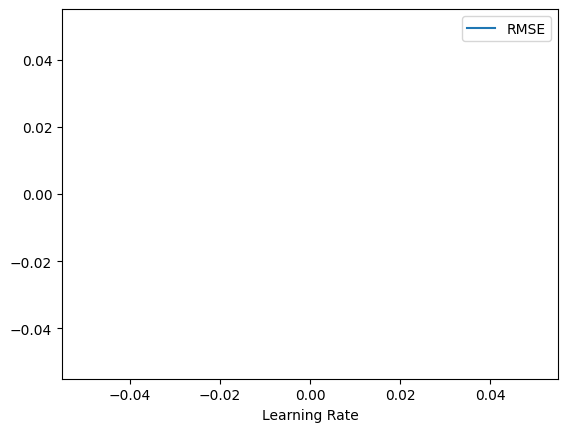

In [55]:
rates = [0.3, 0.5, 0.7, 0.9]
points = []

for rate in rates:
    X_train, X_test, y_train, y_test = split_time_dataset(X, y, 0.75)
    model = LGBMRegressor(n_estimators=50, learning_rate=rate)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Rate: {rate}")
    rmse = print_performance(y_test, y_pred)
    points.append((rate, rmse))
    print()

from matplotlib import pyplot as plt

rates, rmses = zip(*points)

plt.plot(rates, rmses, label='RMSE')
plt.xlabel('Learning Rate')
plt.legend()
plt.show()

**Consigne**: Faire la même chose avec un LGBM de 100 arbres et un autre de 250, puis afficher le résultats avec le précédent.

In [52]:
for rate in rates:
    X_train, X_test, y_train, y_test = split_time_dataset(X, y, 0.75)
    model = LGBMRegressor(n_estimators=100, learning_rate=rate)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Rate: {rate}")
    print_performance(y_test, y_pred)
    print()

for rate in rates:
    X_train, X_test, y_train, y_test = split_time_dataset(X, y, 0.75)
    model = LGBMRegressor(n_estimators=250, learning_rate=rate)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Rate: {rate}")
    print_performance(y_test, y_pred)
    print()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 225195, number of used features: 26
[LightGBM] [Info] Start training from score 21.464236
Rate: 0.3
RMSE: 2.77
R2: 0.98

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 225195, number of used features: 26
[LightGBM] [Info] Start training from score 21.46

On souhaiterai avoir une vision du sur-apprentissage. Pour ce faire, nous allons mesurer l'écart entre les performances sur le dataset d'entraînement et celui de test.

**Consigne** : Reproduire le graphique précédent en ajoutant l'information de la performance sur le jeu d'entraînement.

## Régularisation : par la profondeur

Il y a un sur-apprentissage légé, et on voudrait pour le réduire. Il existe plusieurs possibilités pour cela, mais nous allons nous concentrer sur la profondeur maximale d'un arbre *max_depth*.

On considère dans la suite un modèle avec 250 arbres, et des learning rates entre $10^{-2}$ et $1$. Puisque nous allons reproduire plusieurs fois des cellules de codes similaires, commençons par en faire une fonction.

**Consigne** : Compléter la fonction `compute_performance` qui prend en paramètres:
* *learning_rates*: une liste de learning rates à tester
* *parameter_name*: le nom du paramètre du modèle que l'on souhaite tester
* *parameter_vales*: une liste de valeur à tester pour le paramètre d'intérêt

In [59]:
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def compute_performance(learning_rates, parameter_name, parameter_values, **parameters):
    performances = []
    learning_rates.sort()
    
    for parameter_value in parameter_values:
        performance_train = []
        performance_test = []
        for learning_rate in learning_rates:
            parameters["learning_rate"] = learning_rate
            parameters[parameter_name] = parameter_value
            model = LGBMRegressor(**parameters)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_train)
            performance_train.append(RMSE(y_train, y_pred))

            y_pred = model.predict(X_test)
            performance_test.append(RMSE(y_test, y_pred))

        performances.append({parameter_name: parameter_value,
                             "performances_train": performance_train,
                             "performances_test": performance_test})
        
    return performances

Il nous faut maintenant de la visualisation. On utilisera la fonction `plot_performance` ci-dessous.

**Consigne**: À l'aide la fonction `compute_performance` et de la fonction `plot_performance`, visualiser l'impact de la profondeur des arbres en fonction du learning rate.

In [62]:
import seaborn as sns

def plot_performance(performances, learning_rates, parameter_name):
    plt.figure(figsize=(15, 8))
    for index, element in enumerate(performances):
        color = sns.color_palette()[index]
        parameter_value = element[parameter_name]
        powers = -np.log(learning_rates)/np.log(10)
        plt.plot(powers, element["performances_test"], 'o-', label=f"{parameter_name} = {parameter_value}", color=color)
        plt.plot(powers, element["performances_train"], '--', color=color)


    plt.xlabel(r"$-\log(\eta)$")
    plt.ylabel("RMSE")
    plt.ylim(bottom=0)
    plt.title(f"RMSE en fonction du paramètre {parameter_name} pour un LGBM")
    plt.legend()
    plt.show()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 225195, number of used features: 26
[LightGBM] [Info] Start training from score 21.464236
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

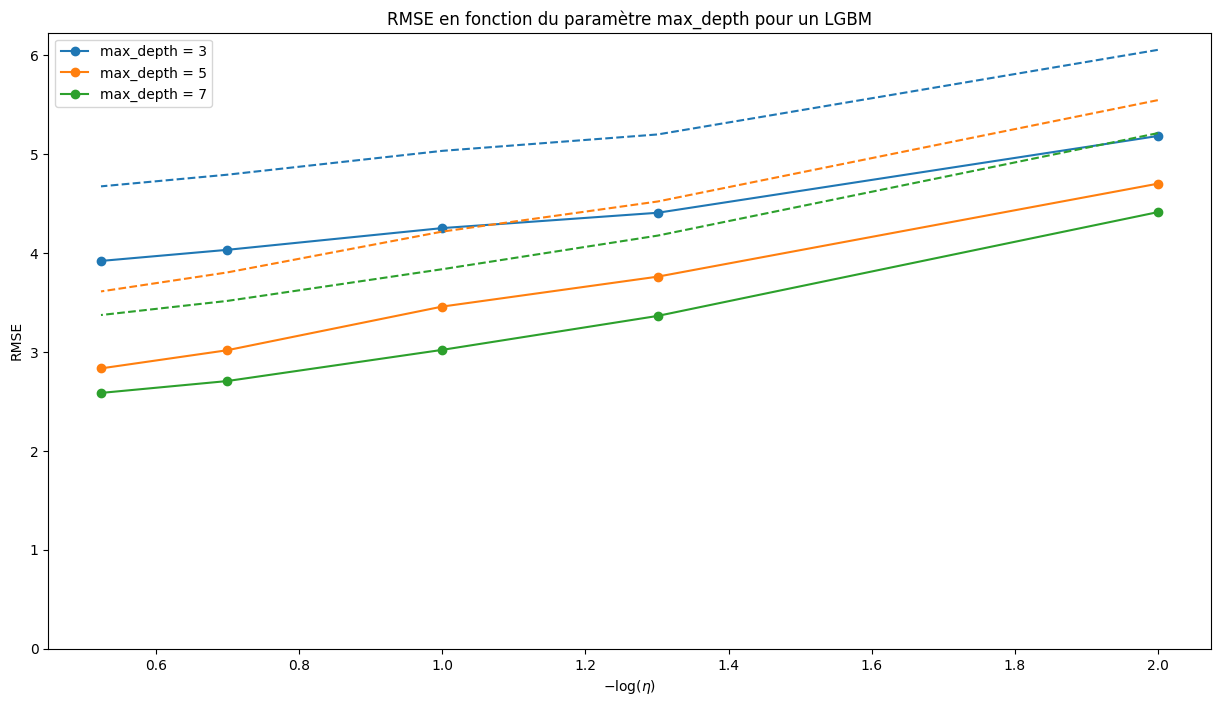

In [63]:
learning_rates = [0.01, 0.05, 0.1, 0.2, 0.3]
parameter_name = 'max_depth'
parameter_values = [3, 5, 7]  # Par exemple, différentes profondeurs d'arbres
parameters = {'n_estimators': 250}  # Nombre d'arbres fixe

performances = compute_performance(learning_rates, parameter_name, parameter_values, **parameters)
plot_performance(performances, learning_rates, parameter_name)

## Importance des features

On se pose la question de l'importance de chacune des informations que l'on a donné au modèle. Pour le faire, on doit d'abord entraîner un modèle.

**Consigne** : Avec l'étude préalable, entraîner un modèle avec les  paramètre de votre choix.

**Consigne** : En utilisant la fonction [`plot_importance`](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.plot_importance.html) de LightGBM, afficher puis commenter l'importance des features.

## Et après ?

On peut s'attaquer à plusieurs axes de réflexion :
1. Comparer les performances entre les principaux algorithmes de boosting
2. Tester d'autres paramètres du boosting
3. Reprendre la préparation des données et l'améliorer.